<!-- dom:TITLE: Polynomial interpolation: Lagrange interpolation -->
# Polynomial interpolation: Lagrange interpolation
<!-- dom:AUTHOR: Anne Kværnø (modified by André Massing) -->
<!-- Author: -->  
**Anne Kværnø (modified by André Massing)**

Date: **Aug 30, 2021**

If you want to have a nicer theme for your jupyter notebook,
download the [cascade stylesheet file tma4125.css](https://www.math.ntnu.no/emner/TMA4125/2020v/part_II/notebooks/tma4125.css)
and execute the next cell:

In [1]:
from IPython.core.display import HTML
def css_styling():
    try:
        with open("tma4125.css", "r") as f:
            styles = f.read()
            return HTML(styles)
    except FileNotFoundError:
        pass #Do nothing

# Comment out next line and execute this cell to restore the default notebook style 
css_styling()

And of course we want to import the required modules.

In [2]:
%matplotlib inline

import numpy as np
from numpy import pi
from numpy.linalg import solve, norm    # Solve linear systems and compute norms
import matplotlib.pyplot as plt

newparams = {'figure.figsize': (6.0, 6.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

# Introduction
Polynomials can be used to approximate functions over some bounded
interval $x \in [a,b]$. Such polynomials can be used for different purposes.
The function itself may be unknown, and only measured data are available. In
this case, a polynomial may be used to find approximations to intermediate
values of the function. Consider for instance the following problem:

The population in Norway in the period 1976 to 2001 is, according to SSB

$$
\begin{array}{l|c|c|c|c|c|c}
\text{year} &  1976  & 1981 & 1986 & 1991 & 1996 & 2001
\\ 
\hline
\text{population} & 4017101 & 4092340 & 4159187 & 4249830 & 4369957 & 4503436
\end{array}
$$

How can we find an estimate for the population in Norway in the years $1983$ and $1999$? Here we
try to find a value *in between* the given data points, that is we "interpolate".
And given that data can we predict what the population in Norway was at years $2010$ and $2020$?
In that scenario we find an estimate for a data point which lies *beyond* the interval boundaries $[1976, 2000]$ provided by the data set,
and thus we "extrapolate"!

Polynomials are
easy to integrate, and can be used to find approximations of integrals
of more complicated functions. This will be exploited later in the
course. And there are plenty of other applications.

In this part of the course, we will only discuss *interpolation polynomials*.

**Interpolation problem.**

Given $n+1$ points $(x_i,y_i)_{i=0}^n$. Find a polynomial $p(x)$ of
lowest possible degree satisfying the *interpolation condition*

<!-- Equation labels as ordinary links -->
<div id="eq:intcond"></div>

$$
\begin{equation} 
    \label{eq:intcond} \tag{1}
    p(x_i) = y_i,\qquad i=0,\dotsc, n. 
\end{equation}
$$

The solution $p(x)$ is called the *interpolation polynomial*, the $x_i$ values
are called *nodes*, and the points $(x_i,y_i)$ *interpolation points*.

**Example 1:** 
Given the points

$$
\begin{array}{c|c|c|c}
x_i & 0 & 2/3 & 1 \\ \hline
y_i & 1 & 1/2 & 0 
\end{array}.
$$

The corresponding interpolation polynomial is

$$
p_2(x)=(-3x^2-x+4)/4
$$

The $y$-values of this example are chosen such that $y_i=\cos{(\pi x_i/2)}$.  So
$p_2(x)$ can be considered as an approximation to $\cos{(\pi x/2)}$ on the interval
$[0,1]$.

In [3]:
# Interpolation data
xdata = [0,2/3., 1]
ydata = [1, 1/2., 0]
# Interpolation polynomial
p2 = lambda x : (-3*x**2 -x + 4)/4.

# Grid points for plotting
x = np.linspace(0,1,100)
y = p2(x)

# Original function
f = np.cos(pi*x/2)

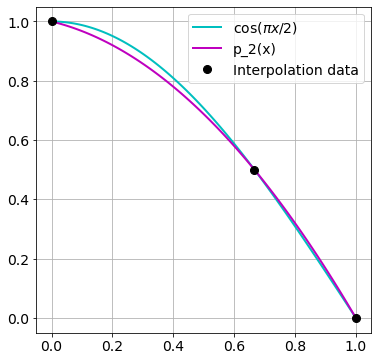

In [4]:
plt.plot(x,f, 'c',x,y,'m', xdata, ydata, "ok")
plt.legend(['$\cos(\pi x/2)$', 'p_2(x)', 'Interpolation data'])

### Topics 

In this note, we will discuss the following: 

* Lagrange Interpolation: A first method to compute the polynomials
* Existence and uniqueness results. 

In the next lecture, we talk about

* Newton Interpolation: Another method to compute the polynomials
* Error analysis: If the polynomial is used to approximate a function, how good is the approximation?
* Improvements: If the nodes $x_i$ can be chosen freely, how should we do it in order to reduce the error? 

## Preliminaries

Let us start with some useful notation and facts about polynomials.  
* A polynomial of degree $n$ is given by

<!-- Equation labels as ordinary links -->
<div id="eq:polynomial"></div>

$$
\begin{equation} \label{eq:polynomial} \tag{2}
 p_n(x) = c_{n}x^n + c_{n-1}x^{n-1} + \cdots + c_1 x_1 + c_0, \qquad  c_i \in
\mathbb{R}, \quad i=0,1,\dotsc,n.
\end{equation}
$$

* $\mathbb{P}_n$ is the set of all polynomials of degree $n$.

* $C^m[a,b]$ is the set of all continuous functions that have continuous first $m$ derivatives.  

* The value $r$ is a root or a zero of a polynomial $p$ if $p(r)=0$.  

* A nonzero polynomial of degree $n$ can never have more than $n$ real roots (there may be less).  
* A polynomial of degree $n$ with $n$ real roots $r_1,r_2,\dotsc,r_n$can be written as

$$
p_n(x) = c(x-r_1)(x-r_2)\dotsm(x-r_n) = c\prod_{i=1}^n(x-r_i).
$$

# Methods
In this section, we present three techniques for finding the interpolation polynomial for a given set of data. 

## The direct approach
For a polynomial of degree $n$ the interpolation condition ([1](#eq:intcond)) is a linear systems of 
$n+1$ equations in $n+1$ unknowns:

$$
\sum_{i=0}^n x_j^i c_i = y_j, \qquad j=0,\dotsc, n.
$$

If we are basically interested in the polynomials themself, given by the coefficients $c_i$, $i=0,1,\dotsc, n$, this is a perfectly fine solution. It is for instance the strategy implemented in MATLAB's interpolation routines. However, in this course, polynomial interpolation will be used as a basic tool to construct other algorithms, in particular for integration. In that case, this is not the most convenient option, so we concentrate on a different strategy, which essentially makes it possible to just write up the polynomials. 

## Lagrange interpolation
Given $n+1$ points  $(x_i,y_i)_{i=0}^n$ with distinct $x_i$ values. 
The *cardinal functions* are defined by:

$$
\ell_i(x) = \prod_{j=0,j\not=i}^n \frac{x-x_j}{x_i-x_j}
  = \frac{x-x_0}{x_i-x_0} \dotsm \frac{x-x_{i-1}}{x_i-x_{i-1}}\cdot \frac{x-x_{i+1}}{x_i-x_{i+1}} \dotsm \frac{x-x_n}{x_i-x_n} , \qquad i=0,\dotsc,n.
$$

The cardinal functions have the following properties:
* $\ell_i \in \mathbb{P}_n$, $i=0,1,\dotsc,n$.

* $\ell_i(x_j) = \delta_{ij} = \begin{cases} 1, & \text{when } i=j \\ 0, & \text{when }i\not=j \end{cases}$.

* They are constructed solely from the nodes $x_i$'s.

* They are linearly independent, and thus form a basis for $\mathbb{P}_{n}$.

**Remark.** The cardinal functions are also often called  **Lagrange polynomials**.

The interpolation polynomial is now given by

$$
p_n(x) = \sum_{i=0}^n y_i \ell_i(x)
$$

since

$$
p_n(x_j) = \sum_{i=0}^n y_i \ell_i(x_j) = y_j, \qquad j=0,\dotsc,n.
$$

**Example 2:**
Given the points:

$$
\begin{array}{c|ccc}
x_i & 0 & 1 & 3 \\ \hline y_i & 3 & 8 & 6
\end{array}.
$$

The corresponding cardinal functions are given by:

$$
\begin{align*}
  \ell_0(x) & = \frac{(x-1)(x-3)}{(0-1)(0-3)}
           = \frac{1}{3}x^2-\frac{4}{3}x+1 \\ 
  \ell_1(x) & = \frac{(x-0)(x-3)}{(1-0)(1-3)}
           = -\frac12 x^2 + \frac32 x \\ 
  \ell_2(x) &= \frac{(x-0)(x-1)}{(3-0)(3-1)} = \frac16 x^2-\frac16 x
\end{align*}
$$

and the interpolation polynomial is given by (check it yourself):

$$
p_2(x) = 3 \ell_0(x) + 8 \ell_1(x) + 6 \ell_2(x) = -2x^2 + 7x + 3.
$$

## Implementation
The method above is implemented as two functions:
* `cardinal(xdata, x)`: Create a list of cardinal functions $\ell_i(x)$ evaluated in $x$.

* `lagrange(ydata, l)`: Create the interpolation polynomial $p_n(x)$.

Here, `xdata` and `ydata` are arrays with the interpolation points, and `x` is an 
array of values in which the polynomials are evaluated. 

You are not required to understand the implementation of these functions, but you should understand how to use them.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In [8]:
def cardinal(xdata, x):
    """
    cardinal(xdata, x): 
    In: xdata, array with the nodes x_i.
        x, array or a scalar of values in which the cardinal functions are evaluated.
    Return: l: a list of arrays of the cardinal functions evaluated in x. 
    """
    n = len(xdata)              # Number of evaluation points x
    l = []
    for i in range(n):          # Loop over the cardinal functions
        li = np.ones(len(x))
        for j in range(n):      # Loop to make the product for l_i
            if i is not j:
                li = li*(x-xdata[j])/(xdata[i]-xdata[j])
        l.append(li)            # Append the array to the list            
    return l

def lagrange(ydata, l):
    """
    lagrange(ydata, l):
    In: ydata, array of the y-values of the interpolation points.
         l, a list of the cardinal functions, given by cardinal(xdata, x)
    Return: An array with the interpolation polynomial. 
    """
    poly = 0                        
    for i in range(len(ydata)):
        poly = poly + ydata[i]*l[i]  
    return poly

**Example 3:**
Test the functions on the interpolation points of Example 2.

In [ ]:
%matplotlib widget

# Example 3
xdata = [0, 1, 3]           # The interpolation points
ydata = [3, 8, 6]
x = np.linspace(0, 3, 101)     # The x-values in which the polynomial is evaluated
l = cardinal(xdata, x)      # Find the cardinal functions evaluated in x
p = lagrange(ydata, l)      # Compute the polynomial evaluated in x
plt.plot(x, p)                  # Plot the polynomial
plt.plot(xdata, ydata, 'o')     # Plot the interpolation points 
plt.title('The interpolation polynomial p(x)')
plt.xlabel('x');

**Numerical exercises:**
1. Plot the cardinal functions for the nodes of Example 1. 

2. Plot the interpolation polynomials for some points of your own choice.

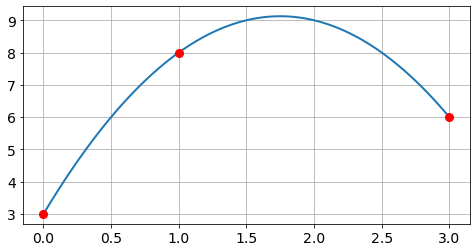

In [14]:
xdata = np.array([0, 1, 3])
ydata = np.array([3, 8, 6])

x = np.linspace(0, 3, 100)

lis = cardinal(xdata, x)
p_n = lagrange(ydata, lis)

#print(x)
#print(lis)
plt.plot(x, p_n)
plt.plot(xdata, ydata, "ro")

In [ ]:
%matplotlib widget
# Insert your code here (use "+" in the Toolbar menu for more cells)


#l_0 = l[0]
#l_0_data = np.zeros(len(xdata))
#l_0_data[0] = 1
#plt.plot(x, l[0], "")
#plt.plot(xdata, l_0_data, "o")
#plt.legend([f"$L_0$", "$L_0(x_i)$"])

legend = []
for i in range(len(xdata)):
    l_i = l[i]
    l_i_data = np.zeros(len(xdata))
    l_i_data[i] = 1
    plt.plot(x, l[i], "")
    plt.plot(xdata, l_i_data, "ro")
    legend += [f"$L_{i}$", f"$L_{i}(x_i)$"]

plt.legend(legend)

## Existence and uniqueness of interpolation polynomials.
We have already proved the existence of such polynomials, simply by constructing
them. But are they unique? The answer is yes!

**Theorem: Existence and uniqueness.**

Given $n+1$ points $(x_i,y_i)_{i=0}^n$ with distinct $x$ values. Then there is
one and only one polynomial $p_n(x) \in \mathbb{P}_n$ satisfying the
interpolation condition

$$
p_n(x_i) = y_i, \qquad i=0,\dotsc, n.
$$

**Proof.**
Suppose there exist two different interpolation polynomials $p_n$ and
$q_n$ of degree $n$ interpolating the same $n+1$ points. The
polynomial $r(x) = p_n(x)-q_n(x)$ is of degree $n$ with zeros in all
the nodes $x_i$, that is a total of $n+1$ zeros. But then $r\equiv 0$,
and the two polynomials $p_n$ and $q_n$ are identical.